# Vaximap EDA

##  Table of Contents

* [Initialisation](#Initialisation)
* [Exploratory Data Analysis](#Exploratory-Data-Analysis)
* [Assessing Patient Clustering](#Assessing-Patient-Clustering)
* [Potential Improvement: HDBSCAN Clustering](#HDBSCAN-Clustering)
* [Appendix: Feedback, Other Suggestions](#Appendix)

## Initialisation

In [1]:
'------------Import Modules------------'
import warnings
warnings.filterwarnings('ignore')

# DS Modules
import random
import datetime
import pandas as pd
import numpy as np
import itertools

# Visualisation
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
import seaborn as sns

# Statistical Tests
from scipy.stats import normaltest, ttest_ind, chi2_contingency, chi2

# Clustering
import hdbscan
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import haversine_distances
from scipy.cluster.hierarchy import dendrogram

# Import dataset
from load_dataset import dataset

# Import functions used in this notebook
from vaximapFunctions import *

In [2]:
# Set up notebook parameters
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
output_notebook() # outputs bokeh plots directly in notebook

Loading BokehJS ...

In [3]:
# Set configuration parameters
random_seed = 42
random.seed = random_seed
centre_lat_lon = (53, -1.2) # defined as approximate centre of UK

## Exploratory Data Analysis

In [4]:
# Plot example row of df
print("Length of raw dataset = {:,}".format(len(dataset)))
print("Number of patients in raw dataset = {:,}".format(dataset.n_patients.sum()))
dataset.head(1)

Length of raw dataset = 8,659
Number of patients in raw dataset = 286,924


,n_patients,n_clusters,latlong,clusters,region,postcodes,created,mode
0,6,1,"[[-0.0011351833333321792, -0.03472788333333332], [0.0018483166666669604, -0.03430198333333312], [0.0005629166666665242, 0.018650416666667002], [-0.0023297833333302265, 0.018505116666666765], [0.002702216666669699, 0.015526416666666876], [-0.0016484833333336724, 0.016347916666666684]]","[[2, 3, 5, 4, 1, 0]]",UK,{},2021-01-23,driving


In [5]:
# Test to identify duplicates: need to convert latlong numpy to string beforehand to be able to drop
df1 = dataset.copy()[["latlong"]]
df1.latlong = df1.latlong.astype("str")
df1 = df1.sort_values("latlong")

# extract number of duplicates from pandas duplicated inbuilt function
df1["is_duplicate"] = df1.duplicated(subset="latlong", keep="last")
print("Number of duplicates = {:,}".format(len(df1.loc[df1.is_duplicate == True])))

Number of duplicates = 2,849


In [6]:
# Demonstrate example of duplicate indices:
df1["is_duplicate_keep_both"] = df1.duplicated(subset="latlong", keep=False)
df1.loc[df1.is_duplicate_keep_both == True][:2]

,latlong,is_duplicate,is_duplicate_keep_both
3091,[[ 0.52405293 3.92101897]\n [ 0.55872712 3.85893157]\n [ 0.54876492 3.89190307]\n [ 0.54966812 3.89196977]\n [ 0.54624852 3.89271367]\n [ 0.54583842 3.89267127]\n [ 0.54535412 3.89462037]\n [ 0.54742872 3.89657457]\n [ 0.55436802 3.85095737]\n [ 0.54456612 3.89271007]\n [ 0.52911782 3.91491207]\n [ 0.52911782 3.91491207]\n [ 0.52992102 3.91602817]\n [ 0.52992102 3.91602817]\n [ 0.52884392 3.90426727]\n [ 0.52714462 3.91622087]\n [ 0.52541342 3.91298777]\n [ 0.52837862 3.91484467]\n [ 0.53021882 3.91953967]\n [ 0.53001182 3.89907477]\n [ 0.52884392 3.90426727]\n [ 0.52619842 3.91898797]\n [ 0.52611872 3.91750837]\n [-12.33426708 -89.75364992]],True,True
3089,[[ 0.52405293 3.92101897]\n [ 0.55872712 3.85893157]\n [ 0.54876492 3.89190307]\n [ 0.54966812 3.89196977]\n [ 0.54624852 3.89271367]\n [ 0.54583842 3.89267127]\n [ 0.54535412 3.89462037]\n [ 0.54742872 3.89657457]\n [ 0.55436802 3.85095737]\n [ 0.54456612 3.89271007]\n [ 0.52911782 3.91491207]\n [ 0.52911782 3.91491207]\n [ 0.52992102 3.91602817]\n [ 0.52992102 3.91602817]\n [ 0.52884392 3.90426727]\n [ 0.52714462 3.91622087]\n [ 0.52541342 3.91298777]\n [ 0.52837862 3.91484467]\n [ 0.53021882 3.91953967]\n [ 0.53001182 3.89907477]\n [ 0.52884392 3.90426727]\n [ 0.52619842 3.91898797]\n [ 0.52611872 3.91750837]\n [-12.33426708 -89.75364992]],True,True


In [7]:
# Remove duplicate indices from raw dataset, keeping "last" assuming earlier duplicates were for testing
df = dataset.loc[dataset.index.isin(df1.loc[df1.is_duplicate == False].index.values)]
print("Length of dataset without duplicates = {:,}".format(len(df)))
print("Number of patients in dataset without duplicates = {:,}".format(df.n_patients.sum()))

Length of dataset without duplicates = 5,810
Number of patients in dataset without duplicates = 179,073


N.B: For now assuming duplicate lat/lon within nested list in one row is because these patients share the same address, rather than clerical error e.g. if user accidentally has duplicates patients in their excel sheet.

In [8]:
# Create new feature: max cluster size
df["max_cluster_size"] = df["clusters"].apply(FindMaxLength)

# Create new feature: postcodes size (used to filter empty postcode dicts)
df["postcodes_size"] = [len(i) for i in df.postcodes]


In [9]:
# Plot usage per day: group by date to get df_usage
df_usage = df.groupby(df.created).count().reset_index()

p1 = figure(x_axis_type="datetime", title="Number of Vaximap requests per date", plot_width=800, plot_height=300)
p1.grid.grid_line_alpha = 0.3
p1.xaxis.axis_label = 'Date'
p1.yaxis.axis_label = 'Request Frequency'
p1.line(df_usage.created, df_usage.n_patients)
show(p1)

n_clusters: 
Number of distinct categories = 31 
Majority class = '1' with 2871 (49%) of samples.
Number of nulls in feature = 0 (0.0%)


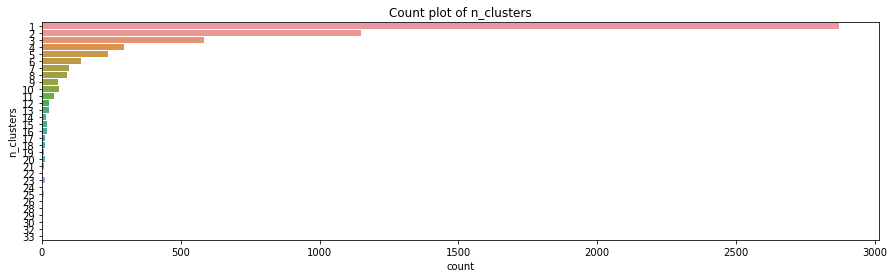

mode: 
Number of distinct categories = 2 
Majority class = 'driving' with 5762 (99%) of samples.
Number of nulls in feature = 0 (0.0%)


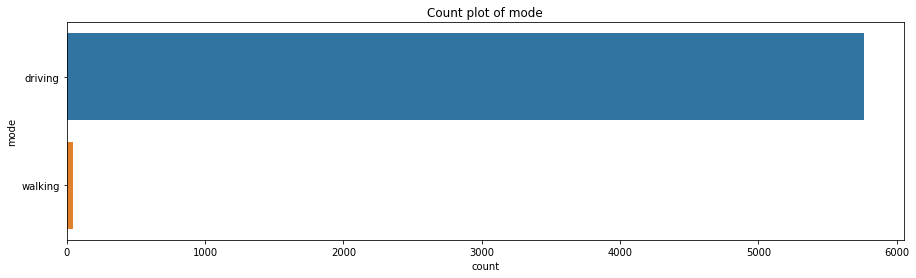

In [10]:
# Categorical variables
categorical_features = ['n_clusters', 'mode'] 
univariateCategorical(df, categorical_features)

,n_patients,n_clusters,max_cluster_size
count,5810.00,5810.00,5810.00
mean,31.00,3.00,12.00
std,41.00,3.00,5.00
min,3.00,1.00,3.00
25%,10.00,1.00,9.00
50%,18.00,2.00,11.00
75%,32.00,3.00,12.00
max,300.00,33.00,25.00
median,18.00,2.00,11.00
skew,3.59,3.56,1.09


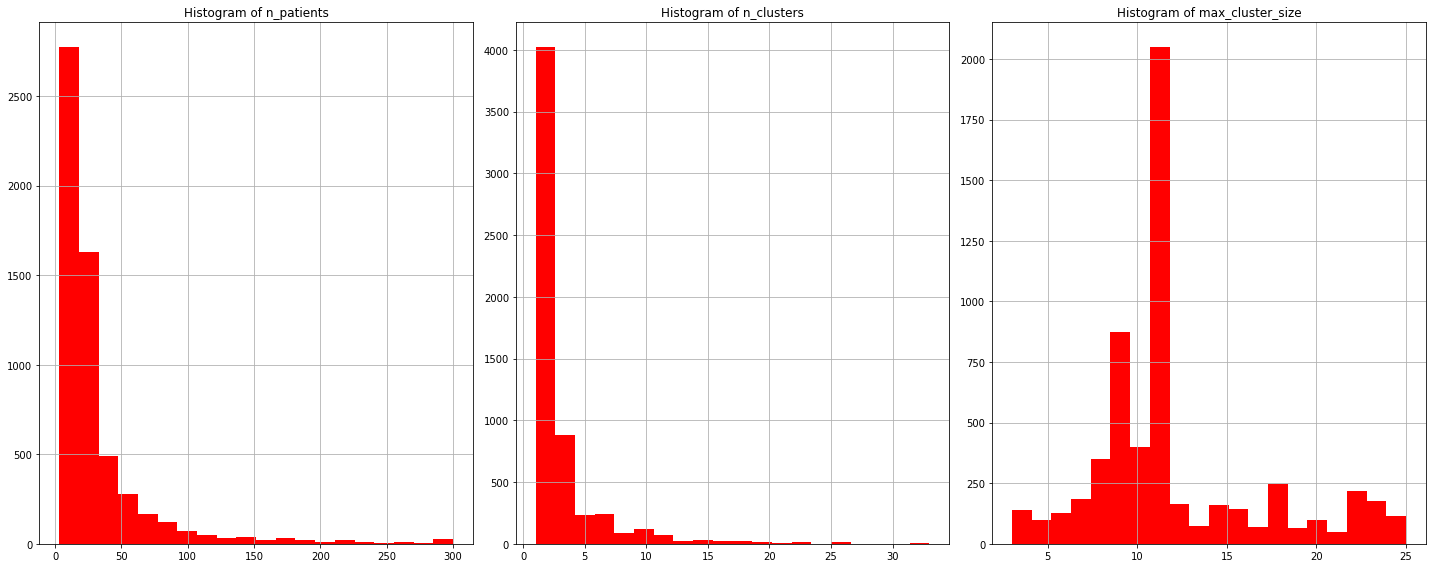

In [11]:
# Numerical variables
numerical_features = ['n_patients', 'n_clusters', 'max_cluster_size'] 
univariateContinuous(df, numerical_features)

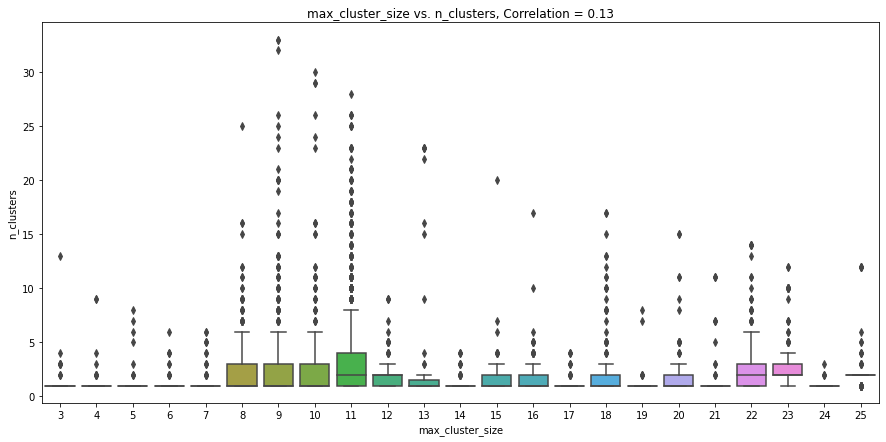

In [12]:
# Plot bivariate analysis between n_clusters and max_cluster_size
bivariateContinuous(df, "n_clusters", "max_cluster_size", corr_type="spearman")

### Key observations:

* Mean n_patients = 31 and long tail, kurtosis = 15.45
* Most requests seemed to have used the website default value D = 11 for cluster size, secondary peak at D = 9 (explained by fact that AstraZeneca has 9 vials). 3 <= D <= 25 (which is what we need, probably due to form constraints set on vaximap website)

## Assessing Patient Clustering

Evaluating how well the iterative K means works. We compare clustering to non-optimised grouping to see how much time is saved in Delivery time (total time = Planning time + Delivery time, in this analysis not focusing on planning time).

In [13]:
# To do

## Hierarchical Clustering

(Iterative) K-Means clustering is being used currently to:
   * Find the centroid of G clusters
   * Populate clusters using ranking based on optimisation penalty, each cluster given patient size <=D, based on distances between patient lat/lon and centroid lat/lon (similar to https://elki-project.github.io/tutorial/same-size_k_means)
   
(we assume that cluster label, which is integer, has no cardinal value).

K-means uses Euclidean-based distance metrics, however since lat/lon coordinates are on a geodesic, there may be some error when comparing distances. One way to get around this is clustering using HDBSCAN (Hierarchical Density-Based Spatial Clustering), but you cannot set the number of clusters: it instead words to find spatially dense areas with nearest neighbour / separation between clusters being prime parameters.

A better tool than HDBSCAN is tree-based Hierarchical clustering, since it can support haversine metrics to accurately calculate lat/lon distance, you can set number of clusters and it is non-parametric. Centre of cluster = mean value of items. There is an iterative fashion to achieve this using the outline described here (http://jmonlong.github.io/Hippocamplus/2018/06/09/cluster-same-size/#iterative-bottom-leaves-hierarchical-clustering).

To then find which centroids map to which patients, there is an optimisation algorithm p-median (more details here: http://courses.ieor.berkeley.edu/ieor151/lecture_notes/ieor151_lec13.pdf) to reduce the distance between centroid and patient. I will look at (i) constraint that means size of cluster = max_cluster_size (and see what happens with leftover patients), or add another objective to maximise patient numbers per cluster up to max cluster size.

N.B. prerequisite is that lat/lon must be converted into radians beforehand. We do this using a simply using inbuilt numpy function radians to convert entire coordinate array.

Other ideas:
Springer: balanced K means: https://link.springer.com/chapter/10.1007/978-3-662-44415-3_4
Kmedoids: https://github.com/OmarAflak/kmedoids/blob/master/constrained_kmedoids.py

In [14]:
df.head(1)

,n_patients,n_clusters,latlong,clusters,region,postcodes,created,mode,max_cluster_size,postcodes_size
2,11,1,"[[-0.00422240000000329, -0.010207700000000014], [0.0017050999999810301, 0.0027945999999999804], [-0.0019168000000036045, -0.004896500000000026], [0.0014654999999947904, 0.007844799999999985], [0.0017771999999922627, -0.0046426000000000245], [0.005728599999990536, 0.0037821999999999856], [-0.004459200000006547, -0.0035046999999999995], [0.0031894999999906304, 0.008110899999999976], [0.0031894999999906304, 0.008110899999999976], [-0.003712000000007265, 0.0028246999999999856], [-0.002745000000018649, -0.01021660000000002]]","[[2, 6, 9, 0, 10, 4, 1, 5, 8, 7, 3]]",UK,{},2021-01-23,driving,11,0


In [15]:
def distanceIterHierarchicalClustering(latlon, n_clusters, max_cluster_size, linkage="average"):
    # convert lat/lon to radians
    latlon_rad = np.radians(latlon)
    print("N patients = {a}, N clusters = {b}, Max size = {c}".format(a=len(latlon), b=n_clusters, c=max_cluster_size))

    
    # compute pairwise haversine distances between each lat/lon point
    haversine_pairwise = haversine_distances(latlon_rad)
    
    # define clustering algorithm and predict for points
    clusterer = AgglomerativeClustering(affinity='precomputed', n_clusters=n_clusters,
                                        linkage=linkage, distance_threshold=None,
                                        compute_distances=True, compute_full_tree=False)
    
    # Iterative clustering method
    
    model = clusterer.fit(haversine_pairwise)
    print(model.get_params())

    
    plot_dendrogram(model, truncate_mode='level', p=3)
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.show()
    model = clusterer.fit_predict(haversine_pairwise)
    
    # convert to indices of lat/lon
    patients = []
    for k in range(n_clusters):
        patients.append([i for i, j in enumerate(model) if j == k])
        
    print(patients)
    return patients
    

N patients = 11, N clusters = 1, Max size = 11
{'affinity': 'precomputed', 'compute_distances': True, 'compute_full_tree': False, 'connectivity': None, 'distance_threshold': None, 'linkage': 'average', 'memory': None, 'n_clusters': 1}


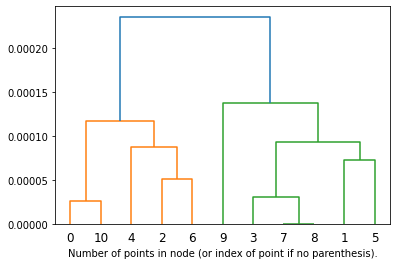

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]
N patients = 20, N clusters = 2, Max size = 10
{'affinity': 'precomputed', 'compute_distances': True, 'compute_full_tree': False, 'connectivity': None, 'distance_threshold': None, 'linkage': 'average', 'memory': None, 'n_clusters': 2}


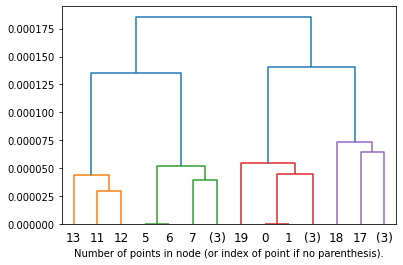

[[0, 1, 2, 3, 4, 14, 15, 16, 17, 18, 19], [5, 6, 7, 8, 9, 10, 11, 12, 13]]
N patients = 32, N clusters = 4, Max size = 10
{'affinity': 'precomputed', 'compute_distances': True, 'compute_full_tree': False, 'connectivity': None, 'distance_threshold': None, 'linkage': 'average', 'memory': None, 'n_clusters': 4}


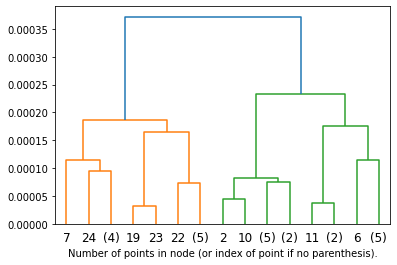

[[6, 11, 12, 13, 14, 15, 16, 17, 18], [19, 22, 23, 25, 26, 27, 30, 31], [0, 1, 2, 3, 4, 5, 8, 9, 10], [7, 20, 21, 24, 28, 29]]


In [16]:
# Output hierarchichal clustering and resulting dendrograms for 3 examples
for i in range(len(df[:3])):
    distanceIterHierarchicalClustering(df["latlong"].values[i], df["n_clusters"].values[i], \
                                   df["max_cluster_size"].values[i], linkage="average")

#### Optimisation algorithm for finding best distribution of patients given number of centroids 
#### WORK IN PROGRESS

Adapted from https://github.com/ralaruri/p_median_python

In [17]:
# change so that rows = patients, columns = centroids, values = distances

In [18]:
from pulp import *
import time

locations_1 = np.radians(df.latlong.values[0])
locations_1 = np.append(locations_1, [[5.56e-04, 1.413e-04]], axis=0)

pairwise_distance_df = pd.DataFrame(haversine_distances(locations_1))
centroids = pairwise_distance_df.keys()
patient = pairwise_distance_df.index


# start counting time
t1=time.time()

p = 2 #  number of locations to optimize to


# declare patient variables
X = LpVariable.dicts('X',(centroids), 0, 1, LpInteger)

# declare decision variables
Y = LpVariable.dicts('Y', (patient, centroids), 0, 1, LpInteger) 

# create the LP object, set up as a MINIMIZATION problem
prob = LpProblem('P Median', LpMinimize)

# prob += sum(sum(D[i][j] * Y[i][j] for j in location) for i in patient)
# pandas iloc looks up values by row(i) and column(j)
prob += sum(sum(pairwise_distance_df.iloc[i,j] * Y[i][j] for j in centroids) for i in patient)

# set up constraints
# This is same as prob += sum([X[j] for j in location]) == p
prob += lpSum([X[j] for j in centroids]) == p

# constraint: make sure that each patient is connected to one centroid
for i in patient: prob += sum(Y[i][j] for j in centroids) == 1

for i in patient:
    for j in centroids: 
        prob +=  Y[i][j] <= X[j]


prob.solve()

#  format output
print(' ')
print("Status:",LpStatus[prob.status])
print(' ')
print("Objective: ",value(prob.objective))
print(' ')

for v in prob.variables():
    subV = v.name.split('_')
    
    if subV[0] == "X" and v.varValue == 1: print('p-Median Node: ', subV[1])

result = []   
'''print(' ')
for v in prob.variables():
    subV = v.name.split('_')
    if subV[0] == "Y" and v.varValue == 1: print(subV[1], ' is connected to', subV[2])'''

print(' ')
for v in prob.variables():
    subV = v.name.split('_')
    if subV[0] == "Y" and v.varValue == 1: 
        result.append((subV[1], ' is connected to', subV[2]))
print(result)

dfo = pd.DataFrame(np.array(result))

 
Status: Optimal
 
Objective:  0.001163296353385322
 
p-Median Node:  2
p-Median Node:  7
 
[('0', ' is connected to', '2'), ('10', ' is connected to', '2'), ('11', ' is connected to', '7'), ('1', ' is connected to', '7'), ('2', ' is connected to', '2'), ('3', ' is connected to', '7'), ('4', ' is connected to', '2'), ('5', ' is connected to', '7'), ('6', ' is connected to', '2'), ('7', ' is connected to', '7'), ('8', ' is connected to', '7'), ('9', ' is connected to', '2')]


## Appendix

###  Potential Areas for Analysis

**1) Evaluate error using UK centre coordinate vs coordinate from high level postcode** <br>
Affects ~10% of points. Would need to convert level postcode into lat/lon. Not sure if interesting for paper as we do not practically use this anonymised dataset when route planning. <br>


### General notes and questions:

Github Codebase:
* requirements.txt: requires "tables" module and also need python=3.8

Paper:
* Cite TSP in line 8
* Need to confirm vial size, in paper says 9 but on website it says 11

Data:
* Website has Time per Patient column, why is this omitted from dataset?

Other Notes (For personal reference):

* D = number of patients per cluster, 3 <= D <= 25. One vial of AstraZeneca has D=9 vials
* Number of groups G = ceil(N/D), N = number of patients
* Iterative k-means produces centroids, then ranks based on optimisation penalty (distance_furthest_centroid - distance_nearest_centroid), so those equidistant to centroids rank less and those close to only one rank more
* I'm assuming that we treat each cluster as one set of delivery and is constrained by D, G = group size = number of delivery sessions
* EMIS Database would likely store patients randomly
* In doc multiplying by 1.2 to take into account fact roads are not straight